# Food Delivery Time Predictor

### Inspiration

I use food delivery apps all the time! There are times when my food arrives quick and times when my food arrives slow, so I wanted to explore which factors affect the delivery time for food, and I wanted to predict delivery times based on these factors through an ML model.

#### Import Libraries & Read Data

In [1422]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [1423]:
train_data = pd.read_csv('train.csv')

In [1424]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(train_data, test_size=0.2, random_state=1)

times = len(train_data) / len(test_data)
print('Train data length is', '%.2f' % times, 'times the length of test data.')
train_percent = (100 / (times + 1)) * times
test_percent = 100 - train_percent
print('This means that the data has', '%.0f' % train_percent + '/' + '%.0f' % test_percent, 'train/test split.')

train_indices = train_data.index
test_indices = test_data.index

Train data length is 4.00 times the length of test data.
This means that the data has 80/20 train/test split.


#### EDA and Feature Engineering

In [1425]:
# take a look at our data
train_data.head(2)

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
25857,0x6337,PUNERES08DEL01,27,4.9,18.534080,73.898520,18.544080,73.908520,15-03-2022,11:55:00,12:00:00,conditions Sunny,High,1,Meal,motorcycle,0,No,Urban,(min) 19
2575,0x1b33,INDORES01DEL03,38,4.5,22.695207,75.866059,22.725207,75.896059,13-03-2022,19:50:00,20:05:00,conditions Sunny,Jam,1,Buffet,motorcycle,1,No,NaN,(min) 17


In [1426]:
test_data.head(2)

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
22766,0x8c53,INDORES16DEL01,23,4.6,22.744648,75.894377,22.784648,75.934377,05-03-2022,13:15:00,13:25:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 23
26061,0xc8b4,AURGRES20DEL01,28,4.9,0.000000,0.000000,0.070000,0.070000,14-02-2022,23:50:00,23:55:00,conditions Sunny,Low,0,Drinks,motorcycle,0,No,Metropolitian,(min) 25


In [1427]:
# the NaN values in the dataset currently are strings, so let's replace them with the actual np.nan value
train_data = train_data.replace('NaN', np.nan, regex=True)
test_data = test_data.replace('NaN', np.nan, regex=True)

# let's see how many nan values are present
nan_count = train_data.isna().sum()
nan_count[nan_count > 0]

Delivery_person_Age        1490
Delivery_person_Ratings    1536
Time_Orderd                1388
Weatherconditions           487
Road_traffic_density        476
multiple_deliveries         794
Festival                    181
City                        953
dtype: int64

In [1428]:
# remove useless columns

# ID of the driver does not affect the delivery time in every way, as the ID's are assigned at random
# order date is very very unlikely to affect the delivery time (potentially holidays, but still unlikely to affect too much)
# vehicle condition likely won't affect since older and newer types of the same vehicle would travel about the same speed
# we already have time ordered so we don't need to keep time order picked up
useless_cols = ['ID', 'Delivery_person_ID', 'Order_Date', 'Vehicle_condition', 'Time_Order_picked']
train_data.drop(useless_cols, axis=1, inplace=True)
test_data.drop(useless_cols, axis=1, inplace=True)
train_data.isna().sum()

Delivery_person_Age            1490
Delivery_person_Ratings        1536
Restaurant_latitude               0
Restaurant_longitude              0
Delivery_location_latitude        0
Delivery_location_longitude       0
Time_Orderd                    1388
Weatherconditions               487
Road_traffic_density            476
Type_of_order                     0
Type_of_vehicle                   0
multiple_deliveries             794
Festival                        181
City                            953
Time_taken(min)                   0
dtype: int64

In [1429]:
train_data.head(2)

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Time_Orderd,Weatherconditions,Road_traffic_density,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
25857,27,4.9,18.534080,73.898520,18.544080,73.908520,11:55:00,conditions Sunny,High,Meal,motorcycle,0,No,Urban,(min) 19
2575,38,4.5,22.695207,75.866059,22.725207,75.896059,19:50:00,conditions Sunny,Jam,Buffet,motorcycle,1,No,NaN,(min) 17


In [1430]:
test_data.head(2)

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Time_Orderd,Weatherconditions,Road_traffic_density,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
22766,23,4.6,22.744648,75.894377,22.784648,75.934377,13:15:00,conditions Cloudy,High,Snack,scooter,1,No,Metropolitian,(min) 23
26061,28,4.9,0.000000,0.000000,0.070000,0.070000,23:50:00,conditions Sunny,Low,Drinks,motorcycle,0,No,Metropolitian,(min) 25


### Begin Engineering Columns

#### Weather Conditions

In [1431]:
print('Old Weather Conditions:', train_data.Weatherconditions.unique())

# we can see that all the weather conditions contain "conditions" in the name so we can remove that
# we can then one hot encode the weather conditions
train_data['Weatherconditions'] = train_data['Weatherconditions'].str.replace("conditions ", "")
print('New Weather Conditions', train_data.Weatherconditions.unique())
test_data['Weatherconditions'] = test_data['Weatherconditions'].str.replace("conditions ", "")

Old Weather Conditions: ['conditions Sunny' 'conditions Windy' 'conditions Sandstorms'
 'conditions Stormy' 'conditions Fog' 'conditions Cloudy' nan]
New Weather Conditions ['Sunny' 'Windy' 'Sandstorms' 'Stormy' 'Fog' 'Cloudy' nan]


In [1432]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
weather_arr = ohe.fit_transform(train_data[['Weatherconditions']]).toarray()
weather_labels = ohe.categories_[0]
weather = pd.DataFrame(weather_arr, columns=weather_labels)
weather = weather.loc[:, weather.columns.notna()]
weather.index = train_indices
train_data = pd.concat([train_data, weather], axis=1)
weather.head(2)

,Cloudy,Fog,Sandstorms,Stormy,Sunny,Windy
25857,0.0,0.0,0.0,0.0,1.0,0.0
2575,0.0,0.0,0.0,0.0,1.0,0.0


In [1433]:
ohe = OneHotEncoder()
weather_arr = ohe.fit_transform(test_data[['Weatherconditions']]).toarray()
weather_labels = ohe.categories_[0]
weather = pd.DataFrame(weather_arr, columns=weather_labels)
weather = weather.loc[:, weather.columns.notna()]
weather.index = test_indices
test_data = pd.concat([test_data, weather], axis=1)
weather.head(2)

,Cloudy,Fog,Sandstorms,Stormy,Sunny,Windy
22766,1.0,0.0,0.0,0.0,0.0,0.0
26061,0.0,0.0,0.0,0.0,1.0,0.0


In [1434]:
train_data.head(2)

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Time_Orderd,Weatherconditions,Road_traffic_density,Type_of_order,...,multiple_deliveries,Festival,City,Time_taken(min),Cloudy,Fog,Sandstorms,Stormy,Sunny,Windy
25857,27,4.9,18.534080,73.898520,18.544080,73.908520,11:55:00,Sunny,High,Meal,...,0,No,Urban,(min) 19,0.0,0.0,0.0,0.0,1.0,0.0
2575,38,4.5,22.695207,75.866059,22.725207,75.896059,19:50:00,Sunny,Jam,Buffet,...,1,No,NaN,(min) 17,0.0,0.0,0.0,0.0,1.0,0.0


In [1435]:
train_data.isna().sum()

Delivery_person_Age            1490
Delivery_person_Ratings        1536
Restaurant_latitude               0
Restaurant_longitude              0
Delivery_location_latitude        0
Delivery_location_longitude       0
Time_Orderd                    1388
Weatherconditions               487
Road_traffic_density            476
Type_of_order                     0
Type_of_vehicle                   0
multiple_deliveries             794
Festival                        181
City                            953
Time_taken(min)                   0
Cloudy                            0
Fog                               0
Sandstorms                        0
Stormy                            0
Sunny                             0
Windy                             0
dtype: int64

#### Traffic Conditions

In [1436]:
print('Traffic:', train_data.Road_traffic_density.unique())
train_data['Road_traffic_density'] = train_data['Road_traffic_density'].str.replace(" ", "")
print('Traffic:', train_data.Road_traffic_density.unique())
test_data['Road_traffic_density'] = test_data['Road_traffic_density'].str.replace(" ", "")

Traffic: ['High ' 'Jam ' 'Low ' 'Medium ' nan]
Traffic: ['High' 'Jam' 'Low' 'Medium' nan]


In [1437]:
# use ordinal encoder
from sklearn.preprocessing import OrdinalEncoder


# save to later check if the same rows have NaN
orig_ind = np.where(train_data['Road_traffic_density'].isna())[0]

oe = OrdinalEncoder(categories=[['Low', 'Medium', 'High', 'Jam']])
train_data.loc[train_data.Road_traffic_density.notna(), ['Road_traffic_density']] = oe.fit_transform(train_data['Road_traffic_density'].dropna().values.reshape(-1,1))

# show that our ordinal encoding did not change the NaN values
new_ind = np.where(train_data['Road_traffic_density'].isna())[0]
print((orig_ind == new_ind).all())

# we can also map the values ourselves instead of using the ordinal encoder
# Even though mapping is much easier here, I wanted to use OrdinalEncoder for this task because it's much more scalable

# traffic_map = {'Low': 0, 'Medium': 1, 'High': 2, 'Jam': 3}
# train_data['Road_traffic_density'] = train_data['Road_traffic_density'].map(traffic_map).fillna(train_data['Road_traffic_density'])

True


In [1438]:
oe = OrdinalEncoder(categories=[['Low', 'Medium', 'High', 'Jam']])
test_data.loc[test_data.Road_traffic_density.notna(), ['Road_traffic_density']] = oe.fit_transform(test_data['Road_traffic_density'].dropna().values.reshape(-1,1))

In [1439]:
train_data.head(2)

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Time_Orderd,Weatherconditions,Road_traffic_density,Type_of_order,...,multiple_deliveries,Festival,City,Time_taken(min),Cloudy,Fog,Sandstorms,Stormy,Sunny,Windy
25857,27,4.9,18.534080,73.898520,18.544080,73.908520,11:55:00,Sunny,2.0,Meal,...,0,No,Urban,(min) 19,0.0,0.0,0.0,0.0,1.0,0.0
2575,38,4.5,22.695207,75.866059,22.725207,75.896059,19:50:00,Sunny,3.0,Buffet,...,1,No,NaN,(min) 17,0.0,0.0,0.0,0.0,1.0,0.0


In [1440]:
# remove the min from time taken so that it can be converted to numeric
train_data['Time_taken(min)'] = train_data['Time_taken(min)'].str.replace("(min) ", "")
test_data['Time_taken(min)'] = test_data['Time_taken(min)'].str.replace("(min) ", "")

# convert columns to floats, ignore any errors such as trying to convert strings
train_data = train_data.apply(pd.to_numeric, errors='ignore')
test_data = test_data.apply(pd.to_numeric, errors='ignore')

#### Age

In [1441]:
train_data.Delivery_person_Age.value_counts()

Delivery_person_Age
35.0    1834
36.0    1814
22.0    1790
30.0    1790
37.0    1789
38.0    1780
28.0    1762
24.0    1756
33.0    1747
25.0    1742
27.0    1736
32.0    1734
26.0    1734
29.0    1724
34.0    1723
21.0    1720
20.0    1707
39.0    1695
23.0    1677
31.0    1661
50.0      39
15.0      30
Name: count, dtype: int64

We notice here that ages 15 and 50 have significantly less data than the other ages.

In [1442]:
test_data.Delivery_person_Age.value_counts()

Delivery_person_Age
32.0    468
29.0    467
31.0    459
24.0    454
39.0    449
36.0    446
34.0    443
33.0    440
38.0    439
37.0    438
30.0    436
21.0    433
25.0    432
20.0    429
35.0    428
26.0    425
28.0    417
27.0    414
23.0    410
22.0    406
50.0     14
15.0      8
Name: count, dtype: int64

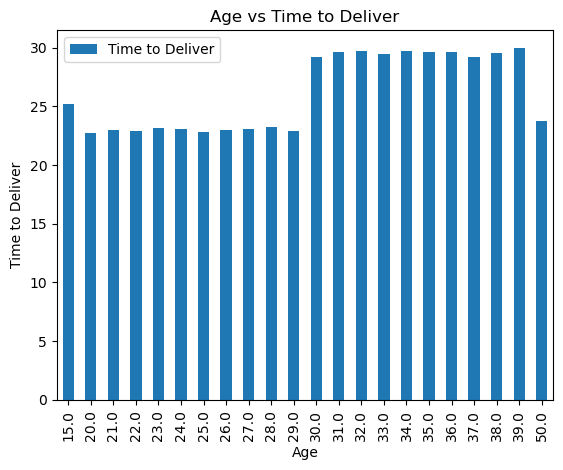

In [1443]:
mean_time_age = train_data.groupby('Delivery_person_Age', as_index=False)['Time_taken(min)'].mean()
mean_time_plot = mean_time_age.plot(x='Delivery_person_Age', y='Time_taken(min)', kind='bar', label='Time to Deliver')
mean_time_plot.set_xlabel('Age')
mean_time_plot.set_ylabel('Time to Deliver')
mean_time_plot.set_title('Age vs Time to Deliver');

We see here that delivery drivers of age 20 to 29 all take roughly the same time to deliver food, drivers of age 30 to 39 all take roughly the same time to deliver food and ages 15 and 50 have more unique values. Although the mean time to deliver for a 50 year old is only slightly above that of the highest mean amongst 20-29 year olds, we will leave 50 year olds in their own category since if we are thinking rationally, there shouldn't be any correlation between the speed of a 20-29 year old and a 50 year old.

Note: the reason we want to group those age groups together is to prevent the model from overfitting the training data.

In [1444]:
# first change values so that age 20 to 29 have same value (maybe string '20s') and same with 30 to 39 ('30s')

# group ages 20 to 29, and ages 30 to 39, we'll use one hot encoding
# i will not be using ordinal encoding here out of the fear that the model may place significance on the order
# it is unlikely that order should have significance here, since there's no clear reason why a 50 year old takes less time than a 30-39 year old etc

ohe = OneHotEncoder()

age_dict = {15: '15', 50: '50'}
keys_20 = [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
keys_30 = [30, 31, 32, 33, 34, 35, 36, 37, 38, 39]

for key in keys_20:
    age_dict[key] = '20-29'

for key in keys_30:
    age_dict[key] = '30-39'

train_data['Delivery_person_Age'] = train_data['Delivery_person_Age'].map(age_dict).fillna(train_data['Delivery_person_Age'])
train_data['Delivery_person_Age'].unique()

array(['20-29', '30-39', nan, '15', '50'], dtype=object)

In [1445]:
age_arr = ohe.fit_transform(train_data[['Delivery_person_Age']]).toarray()
age_labels = ohe.categories_[0]
age = pd.DataFrame(age_arr, columns=age_labels)
age = age.loc[:, age.columns.notna()]
age.index = train_indices
age.head(2)

,15,20-29,30-39,50
25857,0.0,1.0,0.0,0.0
2575,0.0,0.0,1.0,0.0


In [1446]:
train_data = pd.concat([train_data, age], axis=1)
train_data.head(2)

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Time_Orderd,Weatherconditions,Road_traffic_density,Type_of_order,...,Cloudy,Fog,Sandstorms,Stormy,Sunny,Windy,15,20-29,30-39,50
25857,20-29,4.9,18.534080,73.898520,18.544080,73.908520,11:55:00,Sunny,2.0,Meal,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2575,30-39,4.5,22.695207,75.866059,22.725207,75.896059,19:50:00,Sunny,3.0,Buffet,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [1447]:
ohe = OneHotEncoder()

age_dict = {15: '15', 50: '50'}
keys_20 = [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
keys_30 = [30, 31, 32, 33, 34, 35, 36, 37, 38, 39]

for key in keys_20:
    age_dict[key] = '20-29'

for key in keys_30:
    age_dict[key] = '30-39'

test_data['Delivery_person_Age'] = test_data['Delivery_person_Age'].map(age_dict).fillna(test_data['Delivery_person_Age'])

age_arr = ohe.fit_transform(test_data[['Delivery_person_Age']]).toarray()
age_labels = ohe.categories_[0]
age = pd.DataFrame(age_arr, columns=age_labels)
age = age.loc[:, age.columns.notna()]
age.index = test_indices

test_data = pd.concat([test_data, age], axis=1)

#### Time Ordered

In [1448]:
# minutes don't have much significance to time ordered but the hour might so slice to only the hour
train_data['Time_Orderd'] = train_data['Time_Orderd'].str[:2]
test_data['Time_Orderd'] = test_data['Time_Orderd'].str[:2]
train_data['Time_Orderd'].unique()

array(['11', '19', '12', nan, '22', '21', '08', '20', '10', '17', '23',
       '09', '18', '16', '14', '15', '13', '00'], dtype=object)

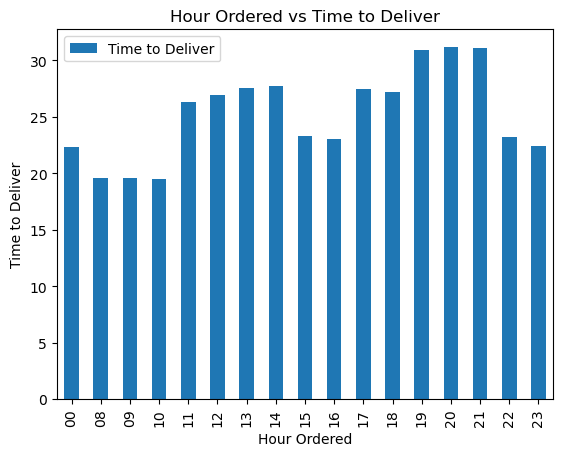

In [1449]:
# plot it
mean_time_hour = train_data.groupby('Time_Orderd', as_index=False)['Time_taken(min)'].mean()
mean_time_plot = mean_time_hour.plot(x='Time_Orderd', y='Time_taken(min)', kind='bar', label='Time to Deliver')
mean_time_plot.set_xlabel('Hour Ordered')
mean_time_plot.set_ylabel('Time to Deliver')
mean_time_plot.set_title('Hour Ordered vs Time to Deliver');

We see that it takes longer around lunch time and dinner time to deliver food so we can group between meal times vs non meal times.

In [1450]:
meal_dict = {}
meal_times = ['11', '12', '13', '14', '17', '18', '19', '20', '21']
non_meal_times = ['00', '08', '09', '10', '15', '16', '22', '23']

for key in meal_times:
    meal_dict[key] = 'Meal_Time'

for key in non_meal_times:
    meal_dict[key] = 'Not_Meal_Time'

train_data['Time_Orderd'] = train_data['Time_Orderd'].map(meal_dict).fillna(train_data['Time_Orderd'])
train_data['Time_Orderd'].unique()

array(['Meal_Time', nan, 'Not_Meal_Time'], dtype=object)

In [1451]:
ohe = OneHotEncoder()
meal_arr = ohe.fit_transform(train_data[['Time_Orderd']]).toarray()
meal_labels = ohe.categories_[0]
meal = pd.DataFrame(meal_arr, columns=meal_labels)
meal = meal.loc[:, meal.columns.notna()]
meal.index = train_indices
meal.head(2)

,Meal_Time,Not_Meal_Time
25857,1.0,0.0
2575,1.0,0.0


In [1452]:
train_data = pd.concat([train_data, meal], axis=1)
train_data.head(3)

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Time_Orderd,Weatherconditions,Road_traffic_density,Type_of_order,...,Sandstorms,Stormy,Sunny,Windy,15,20-29,30-39,50,Meal_Time,Not_Meal_Time
25857,20-29,4.9,18.534080,73.898520,18.544080,73.908520,Meal_Time,Sunny,2.0,Meal,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2575,30-39,4.5,22.695207,75.866059,22.725207,75.896059,Meal_Time,Sunny,3.0,Buffet,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
37903,20-29,4.1,17.450851,78.379347,17.460851,78.389347,Meal_Time,Sunny,2.0,Snack,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [1453]:
meal_dict = {}
meal_times = ['11', '12', '13', '14', '17', '18', '19', '20', '21']
non_meal_times = ['00', '08', '09', '10', '15', '16', '22', '23']

for key in meal_times:
    meal_dict[key] = 'Meal_Time'

for key in non_meal_times:
    meal_dict[key] = 'Not_Meal_Time'

test_data['Time_Orderd'] = test_data['Time_Orderd'].map(meal_dict).fillna(test_data['Time_Orderd'])

ohe = OneHotEncoder()
meal_arr = ohe.fit_transform(test_data[['Time_Orderd']]).toarray()
meal_labels = ohe.categories_[0]
meal = pd.DataFrame(meal_arr, columns=meal_labels)
meal = meal.loc[:, meal.columns.notna()]
meal.index = test_indices

test_data = pd.concat([test_data, meal], axis=1)

#### Distance from Restaurant to Customer Location

We use the haversine formula for this, which calculates the distance between two places based on their latitude and longitude angles.

In [1454]:
def deg_to_rads(deg):
    return deg * np.pi / 180

def my_haversine(row):
    r_lat1 = deg_to_rads(row['Restaurant_latitude'])
    r_lat2 = deg_to_rads(row['Delivery_location_latitude'])
    r_lon1 = deg_to_rads(row['Restaurant_longitude'])
    r_lon2 = deg_to_rads(row['Delivery_location_longitude'])
    dist_lat = r_lat2 - r_lat1
    dist_lon = r_lon2 - r_lon1
    calc_1 = np.sin(dist_lat / 2) ** 2 + np.cos(r_lat1) * np.cos(r_lat2) * (np.sin(dist_lon / 2) ** 2)
    calc_2 = 2 * np.arctan2(np.sqrt(calc_1), np.sqrt(1 - calc_1))
    earth_rad = 6371
    return earth_rad * calc_2

In [1455]:
train_data['Distance'] = train_data.apply(my_haversine, axis=1)
train_data.drop(['Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude'], axis=1, inplace=True)

test_data['Distance'] = test_data.apply(my_haversine, axis=1)
test_data.drop(['Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude'], axis=1, inplace=True)

In [1456]:
train_data.head(2)

,Delivery_person_Age,Delivery_person_Ratings,Time_Orderd,Weatherconditions,Road_traffic_density,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,...,Stormy,Sunny,Windy,15,20-29,30-39,50,Meal_Time,Not_Meal_Time,Distance
25857,20-29,4.9,Meal_Time,Sunny,2.0,Meal,motorcycle,0.0,No,Urban,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.532275
2575,30-39,4.5,Meal_Time,Sunny,3.0,Buffet,motorcycle,1.0,No,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,4.538408


#### Type of Order

In [1457]:
train_data['Type_of_order'].unique()

array(['Meal ', 'Buffet ', 'Snack ', 'Drinks '], dtype=object)

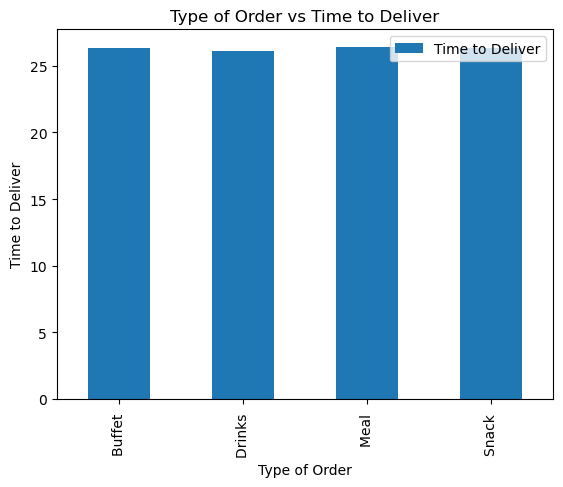

In [1458]:
mean_time_type = train_data.groupby('Type_of_order', as_index=False)['Time_taken(min)'].mean()
mean_time_plot = mean_time_type.plot(x='Type_of_order', y='Time_taken(min)', kind='bar', label='Time to Deliver')
mean_time_plot.set_xlabel('Type of Order')
mean_time_plot.set_ylabel('Time to Deliver')
mean_time_plot.set_title('Type of Order vs Time to Deliver');

The type of order doesn't seem to affect the time to deliver at all! So we will just drop the column.

In [1459]:
train_data.drop('Type_of_order', axis=1, inplace=True)
test_data.drop('Type_of_order', axis=1, inplace=True)

#### Type of Vehicle

In [1460]:
train_data['Type_of_vehicle'].unique()

array(['motorcycle ', 'scooter ', 'electric_scooter ', 'bicycle '],
      dtype=object)

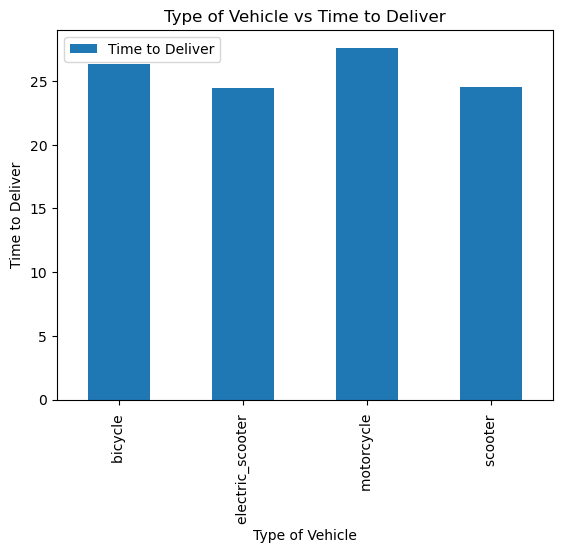

In [1461]:
mean_time_vehicle = train_data.groupby('Type_of_vehicle', as_index=False)['Time_taken(min)'].mean()
mean_time_plot = mean_time_vehicle.plot(x='Type_of_vehicle', y='Time_taken(min)', kind='bar', label='Time to Deliver')
mean_time_plot.set_xlabel('Type of Vehicle')
mean_time_plot.set_ylabel('Time to Deliver')
mean_time_plot.set_title('Type of Vehicle vs Time to Deliver');

In [1462]:
mean_time_vehicle

,Type_of_vehicle,Time_taken(min)
0,bicycle,26.316667
1,electric_scooter,24.478076
2,motorcycle,27.627511
3,scooter,24.500773


It seems to be the case that scooters take less time than bikes and motorcycles! Likely because the scooter ubers probably deliver to shorter distances :)

Let's group scooters, and then leave bikes and motorcycles alone.

In [1463]:
vehicle_dict = {'motorcycle ': 'motorcycle', 'electric_scooter ': 'scooter', 'bicycle ': 'bicycle', 'scooter ': 'scooter'}

train_data['Type_of_vehicle'] = train_data['Type_of_vehicle'].map(vehicle_dict).fillna(train_data['Type_of_vehicle'])
test_data['Type_of_vehicle'] = test_data['Type_of_vehicle'].map(vehicle_dict).fillna(test_data['Type_of_vehicle'])
train_data['Type_of_vehicle'].unique()

array(['motorcycle', 'scooter', 'bicycle'], dtype=object)

In [1464]:
# one hot encode the vehicles
ohe = OneHotEncoder()
vehicle_arr = ohe.fit_transform(train_data[['Type_of_vehicle']]).toarray()
vehicle_labels = ohe.categories_[0]
vehicle = pd.DataFrame(vehicle_arr, columns=vehicle_labels)
vehicle = vehicle.loc[:, vehicle.columns.notna()]
vehicle.index = train_indices
vehicle.head(2)

,bicycle,motorcycle,scooter
25857,0.0,1.0,0.0
2575,0.0,1.0,0.0


In [1465]:
train_data = pd.concat([train_data, vehicle], axis=1)
train_data.head(2)

,Delivery_person_Age,Delivery_person_Ratings,Time_Orderd,Weatherconditions,Road_traffic_density,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),...,15,20-29,30-39,50,Meal_Time,Not_Meal_Time,Distance,bicycle,motorcycle,scooter
25857,20-29,4.9,Meal_Time,Sunny,2.0,motorcycle,0.0,No,Urban,19,...,0.0,1.0,0.0,0.0,1.0,0.0,1.532275,0.0,1.0,0.0
2575,30-39,4.5,Meal_Time,Sunny,3.0,motorcycle,1.0,No,NaN,17,...,0.0,0.0,1.0,0.0,1.0,0.0,4.538408,0.0,1.0,0.0


In [1466]:
ohe = OneHotEncoder()
vehicle_arr = ohe.fit_transform(test_data[['Type_of_vehicle']]).toarray()
vehicle_labels = ohe.categories_[0]
vehicle = pd.DataFrame(vehicle_arr, columns=vehicle_labels)
vehicle.index = test_indices

test_data = pd.concat([test_data, vehicle], axis=1)

#### Festival

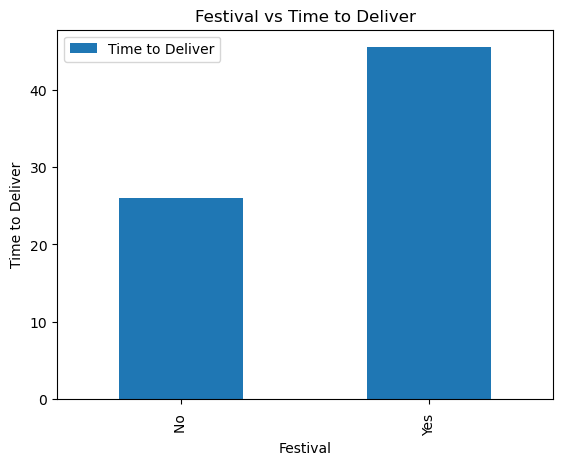

In [1467]:
time_fest = train_data.groupby('Festival', as_index=False)['Time_taken(min)'].mean()
time_plot = time_fest.plot(x='Festival', y='Time_taken(min)', kind='bar', label='Time to Deliver')
time_plot.set_xlabel('Festival')
time_plot.set_ylabel('Time to Deliver')
time_plot.set_title('Festival vs Time to Deliver');

There is clearly an increase in the time to deliver when a festival is taking place. This also makes sense because **not sure if it's festival going on slowing down car or if it's festival order so more food so take longer but either way it works.**

In [1468]:
oe = OrdinalEncoder(categories=[['No ', 'Yes ']])
train_data.loc[train_data['Festival'].notna(), ['Festival']] = oe.fit_transform(train_data['Festival'].dropna().values.reshape(-1,1))

oe = OrdinalEncoder(categories=[['No ', 'Yes ']])
test_data.loc[test_data['Festival'].notna(), ['Festival']] = oe.fit_transform(test_data['Festival'].dropna().values.reshape(-1,1))

In [1469]:
train_data.head(2)

,Delivery_person_Age,Delivery_person_Ratings,Time_Orderd,Weatherconditions,Road_traffic_density,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),...,15,20-29,30-39,50,Meal_Time,Not_Meal_Time,Distance,bicycle,motorcycle,scooter
25857,20-29,4.9,Meal_Time,Sunny,2.0,motorcycle,0.0,0.0,Urban,19,...,0.0,1.0,0.0,0.0,1.0,0.0,1.532275,0.0,1.0,0.0
2575,30-39,4.5,Meal_Time,Sunny,3.0,motorcycle,1.0,0.0,NaN,17,...,0.0,0.0,1.0,0.0,1.0,0.0,4.538408,0.0,1.0,0.0


#### City

In [1470]:
train_data.City.value_counts()

City
Metropolitian     27297
Urban              8093
Semi-Urban          131
Name: count, dtype: int64

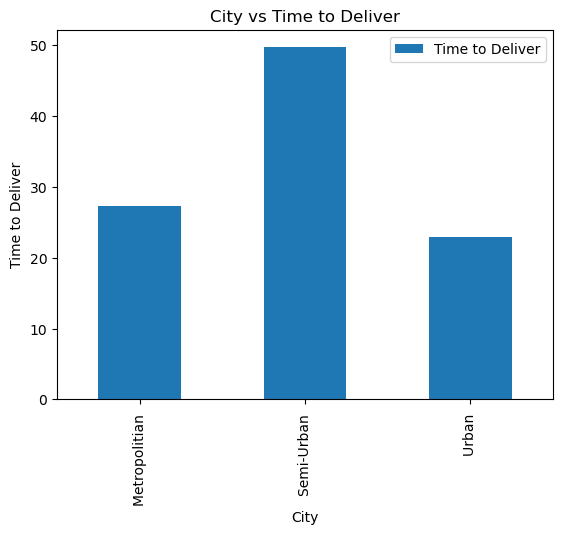

In [1471]:
time_city = train_data.groupby('City', as_index=False)['Time_taken(min)'].mean()
time_plot = time_city.plot(x='City', y='Time_taken(min)', kind='bar', label='Time to Deliver')
time_plot.set_xlabel('City')
time_plot.set_ylabel('Time to Deliver')
time_plot.set_title('City vs Time to Deliver');

In [1472]:
time_city

,City,Time_taken(min)
0,Metropolitian,27.325787
1,Semi-Urban,49.717557
2,Urban,22.978994


This makes sense since urban areas are the most dense, then metropolitian, then semi-urban, so let's use an ordinal encoder.

In [1473]:
oe = OrdinalEncoder(categories=[['Urban ', 'Metropolitian ', 'Semi-Urban ']])
train_data.loc[train_data['City'].notna(), ['City']] = oe.fit_transform(train_data['City'].dropna().values.reshape(-1,1))

oe = OrdinalEncoder(categories=[['Urban ', 'Metropolitian ', 'Semi-Urban ']])
test_data.loc[test_data['City'].notna(), ['City']] = oe.fit_transform(test_data['City'].dropna().values.reshape(-1,1))

In [1474]:
train_data.head(2)

,Delivery_person_Age,Delivery_person_Ratings,Time_Orderd,Weatherconditions,Road_traffic_density,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),...,15,20-29,30-39,50,Meal_Time,Not_Meal_Time,Distance,bicycle,motorcycle,scooter
25857,20-29,4.9,Meal_Time,Sunny,2.0,motorcycle,0.0,0.0,0.0,19,...,0.0,1.0,0.0,0.0,1.0,0.0,1.532275,0.0,1.0,0.0
2575,30-39,4.5,Meal_Time,Sunny,3.0,motorcycle,1.0,0.0,NaN,17,...,0.0,0.0,1.0,0.0,1.0,0.0,4.538408,0.0,1.0,0.0


#### Delivery Drivers Rating

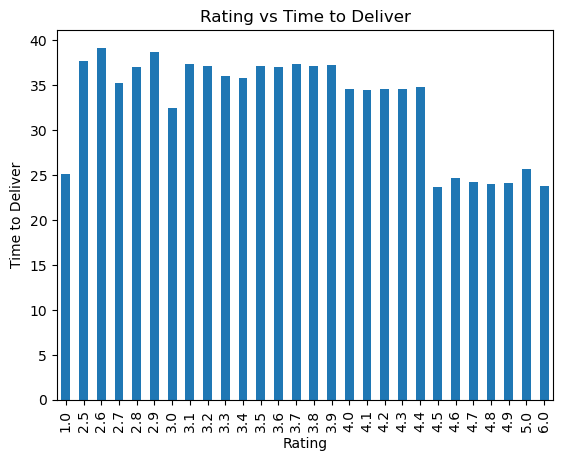

In [1475]:
time_rating = train_data.groupby('Delivery_person_Ratings')['Time_taken(min)'].mean()
time_plot = time_rating.plot(x='Delivery_person_Ratings', y='Time_taken(min)', kind='bar', label='Time to Deliver')
time_plot.set_xlabel('Rating')
time_plot.set_ylabel('Time to Deliver')
time_plot.set_title('Rating vs Time to Deliver');

In [1476]:
(train_data['Delivery_person_Ratings'] == 1).sum()

30

Rating of 2.5 to 4.4 seem to have similar delivery times, ratings 4.5 to 6.0 seem to have similar delivery times, so i will group these together, makes sense cause higher ratings normally means faster shipping times. A rating of 1 seems to be closer to the higher ratings, but if we look at the value counts, i don't believe there to be a big enough sample size for 1 star rating drivers, and it doesn't make sense that a 1 star driver would take the same amount of time as higher rating so i will put 1 star drivers in their own category, resulting in 3 total categories.

In [1477]:
ratings_dict = {1.0: '1.0'}
low_ratings = [2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4]
high_ratings = [4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 6.0]

for rating in low_ratings:
    ratings_dict[rating] = '2.5-4.4'

for rating in high_ratings:
    ratings_dict[rating] = '4.5-6.0'

train_data['Delivery_person_Ratings'] = train_data['Delivery_person_Ratings'].map(ratings_dict).fillna(train_data['Delivery_person_Ratings'])

test_data['Delivery_person_Ratings'] = test_data['Delivery_person_Ratings'].map(ratings_dict).fillna(test_data['Delivery_person_Ratings'])


In [1478]:
train_data['Delivery_person_Ratings'].value_counts()

Delivery_person_Ratings
4.5-6.0    28534
2.5-4.4     6374
1.0           30
Name: count, dtype: int64

In [1479]:
# one hot encode the ratings
# Note: we are not using ordinal encoder here cause

ohe = OneHotEncoder()
ratings_arr = ohe.fit_transform(train_data[['Delivery_person_Ratings']]).toarray()
ratings_labels = ohe.categories_[0]
ratings = pd.DataFrame(ratings_arr, columns=ratings_labels)
ratings = ratings.loc[:, ratings.columns.notna()]
ratings.index = train_indices

In [1480]:
train_data = pd.concat([train_data, ratings], axis=1)
train_data.head(3)

,Delivery_person_Age,Delivery_person_Ratings,Time_Orderd,Weatherconditions,Road_traffic_density,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),...,50,Meal_Time,Not_Meal_Time,Distance,bicycle,motorcycle,scooter,1.0,2.5-4.4,4.5-6.0
25857,20-29,4.5-6.0,Meal_Time,Sunny,2.0,motorcycle,0.0,0.0,0.0,19,...,0.0,1.0,0.0,1.532275,0.0,1.0,0.0,0.0,0.0,1.0
2575,30-39,4.5-6.0,Meal_Time,Sunny,3.0,motorcycle,1.0,0.0,NaN,17,...,0.0,1.0,0.0,4.538408,0.0,1.0,0.0,0.0,0.0,1.0
37903,20-29,2.5-4.4,Meal_Time,Sunny,2.0,motorcycle,2.0,0.0,1.0,46,...,0.0,1.0,0.0,1.536752,0.0,1.0,0.0,0.0,1.0,0.0


In [1481]:
ohe = OneHotEncoder()
ratings_arr = ohe.fit_transform(test_data[['Delivery_person_Ratings']]).toarray()
ratings_labels = ohe.categories_[0]
ratings = pd.DataFrame(ratings_arr, columns=ratings_labels)
ratings = ratings.loc[:, ratings.columns.notna()]
ratings.index = test_indices

test_data = pd.concat([test_data, ratings], axis=1)

#### Multiple Deliveries

In [1482]:
train_data['multiple_deliveries'].value_counts()

multiple_deliveries
1.0    22556
0.0    11265
2.0     1570
3.0      289
Name: count, dtype: int64

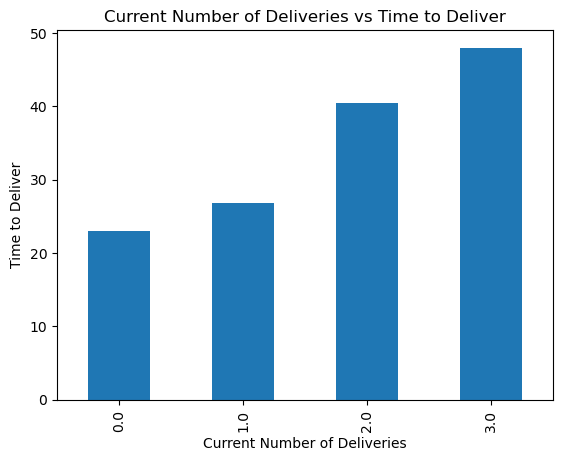

In [1483]:
time_mult_deliv = train_data.groupby('multiple_deliveries')['Time_taken(min)'].mean()
time_plot = time_mult_deliv.plot(x='multiple_deliveries', y='Time_taken(min)', kind='bar', label='Time to Deliver')
time_plot.set_xlabel('Current Number of Deliveries')
time_plot.set_ylabel('Time to Deliver')
time_plot.set_title('Current Number of Deliveries vs Time to Deliver');

We see that there is clearly a steady increase in the time it takes to deliver relative to the number of deliveries, which also makes sense since if a driver has to make multiple deliveries, they will take longer for the later deliveries. We can just keep multiple_deliveries as is.

Let's convert festival and city values to floats so that our model can work with them.

In [1484]:
train_data['Festival'] = train_data['Festival'].astype(float)
train_data['City'] = train_data['City'].astype(float)

test_data['Festival'] = test_data['Festival'].astype(float)
test_data['City'] = test_data['City'].astype(float)

#### Replace Missing Values

Now let us check how to replace the NaN values for the different columns.

In [1485]:
nan_count = train_data.isna().sum()
nan_count[nan_count > 0]

Delivery_person_Age        1490
Delivery_person_Ratings    1536
Time_Orderd                1388
Weatherconditions           487
Road_traffic_density        476
multiple_deliveries         794
Festival                    181
City                        953
dtype: int64

In [1486]:
train_data[(train_data['Time_Orderd'].isna()) & (train_data['Delivery_person_Age'].isna()) & (train_data['Delivery_person_Ratings'].isna()) & (train_data['Road_traffic_density'].isna()) & (train_data['multiple_deliveries'].isna())].shape[0]

9

Without the time ordered, or the age, rating, road traffic, and multiple deliveries, it's really tough to guess for these entries so i will remove these rows from the training data since they are outliers in the sense that they are lacking too much information.

In [1487]:
columns_check = ['Time_Orderd', 'Delivery_person_Age', 'Delivery_person_Ratings', 'Road_traffic_density', 'multiple_deliveries']
train_data = train_data.dropna(subset=columns_check, how='all')
test_data = test_data.dropna(subset=columns_check, how='all')

In [1488]:
train_data.corr(numeric_only=True)

,Road_traffic_density,multiple_deliveries,Festival,City,Time_taken(min),Cloudy,Fog,Sandstorms,Stormy,Sunny,...,50,Meal_Time,Not_Meal_Time,Distance,bicycle,motorcycle,scooter,1.0,2.5-4.4,4.5-6.0
Road_traffic_density,1.000000,0.157125,0.121690,0.085213,0.419270,0.003845,0.000788,-0.003171,-0.011175,0.004406,...,NaN,0.747065,-0.753520,-0.002859,NaN,-0.004260,0.004260,NaN,0.107830,-0.098039
multiple_deliveries,0.157125,1.000000,0.139731,0.088635,0.383759,0.045172,0.052281,-0.012445,-0.006968,-0.073888,...,-0.007470,0.135841,-0.140579,-0.001975,0.002505,0.070862,-0.071106,-0.003948,0.146335,-0.138953
Festival,0.121690,0.139731,1.000000,0.050999,0.291210,0.041805,0.045805,-0.024608,-0.020075,-0.029559,...,0.001356,0.084479,-0.086295,0.007366,-0.000845,0.057664,-0.057625,0.002775,0.071275,-0.066222
City,0.085213,0.088635,0.050999,1.000000,0.217589,0.024601,0.023553,-0.007122,-0.004197,-0.045296,...,0.003478,0.082565,-0.085782,-0.004694,0.001873,0.041900,-0.042068,-0.007457,0.080738,-0.077933
Time_taken(min),0.419270,0.383759,0.291210,0.217589,1.000000,0.128639,0.123596,-0.017747,-0.023133,-0.208578,...,-0.008852,0.367098,-0.373656,-0.002128,-0.000738,0.164454,-0.164480,-0.003489,0.428013,-0.394639
Cloudy,0.003845,0.045172,0.041805,0.024601,0.128639,1.000000,-0.201022,-0.198698,-0.199506,-0.192285,...,-0.014607,0.007591,0.002672,-0.013271,-0.017971,-0.000569,0.002033,-0.012809,-0.007003,0.015325
Fog,0.000788,0.052281,0.045805,0.023553,0.123596,-0.201022,1.000000,-0.200445,-0.201261,-0.193976,...,-0.014735,0.005501,0.007677,-0.021454,-0.018129,0.002786,-0.001312,-0.012922,-0.015170,0.028970
Sandstorms,-0.003171,-0.012445,-0.024608,-0.007122,-0.017747,-0.198698,-0.200445,1.000000,-0.198934,-0.191733,...,-0.014565,-0.000179,0.008598,-0.016310,-0.017919,0.004771,-0.003315,-0.012772,0.051694,-0.039454
Stormy,-0.011175,-0.006968,-0.020075,-0.004197,-0.023133,-0.199506,-0.201261,-0.198934,1.000000,-0.192513,...,-0.014624,-0.005316,0.018158,-0.019259,-0.017992,0.003764,-0.002301,-0.012824,0.042411,-0.024194
Sunny,0.004406,-0.073888,-0.029559,-0.045296,-0.208578,-0.192285,-0.193976,-0.191733,-0.192513,1.000000,...,-0.014095,0.017687,-0.005524,-0.020678,-0.017341,0.004652,-0.003243,-0.012360,-0.095902,0.101770


The first thing I've noticed is that road traffic density seems to be heavily related to meal times, which makes sense since there would be more cars on the road during break / meal times.

In [1489]:
train_data[(train_data['Road_traffic_density'].isna()) & (train_data['Time_Orderd'].isna())].shape[0]

467

In [1490]:
train_data[(train_data['Road_traffic_density'].isna())].shape[0]

467

We can also see here that every single nan value in traffic density also has a nan value in time ordered / meal time.

In [1491]:
train_data.groupby('Road_traffic_density')['Meal_Time'].mean()

Road_traffic_density
0.0    0.012898
1.0    0.839267
2.0    0.954904
3.0    0.947563
Name: Meal_Time, dtype: float64

We see here that as long as there is even 1 amount of traffic density, then there's a very likely chance that it is a meal time. So let's replace the meal times with 1 if the traffic density is 1 to 3 and otherwise if density is 0, then replace the not meal time with 1.

In [1492]:
# dictionary to map values
traffic_dict = {0:0, 1:1, 2:1, 3:1}
oppo_traf_dict = {0:1, 1:0, 2:0, 3:0}

# get the rows that have time ordered missing
nan_meal_rows = train_data[train_data['Time_Orderd'].isna()]
train_data.loc[nan_meal_rows.index, 'Meal_Time'] = train_data.loc[nan_meal_rows.index, 'Road_traffic_density'].map(traffic_dict).fillna(train_data['Meal_Time'])
train_data.loc[nan_meal_rows.index, 'Not_Meal_Time'] = train_data.loc[nan_meal_rows.index, 'Road_traffic_density'].map(oppo_traf_dict).fillna(train_data['Not_Meal_Time'])

nan_meal_rows = test_data[test_data['Time_Orderd'].isna()]
test_data.loc[nan_meal_rows.index, 'Meal_Time'] = test_data.loc[nan_meal_rows.index, 'Road_traffic_density'].map(traffic_dict).fillna(test_data['Meal_Time'])
test_data.loc[nan_meal_rows.index, 'Not_Meal_Time'] = test_data.loc[nan_meal_rows.index, 'Road_traffic_density'].map(oppo_traf_dict).fillna(test_data['Not_Meal_Time'])

The only other slight correlation is the younger drivers getting rated higher compared to the older drivers which also makes sense since the younger drivers probably understand the delivery apps more and probably move around a little faster.

In [1493]:
train_data[(train_data['Delivery_person_Age'].isna())].shape[0]

1481

In [1494]:
train_data[(train_data['Delivery_person_Ratings'].isna())].shape[0]

1527

In [1495]:
train_data[(train_data['Delivery_person_Age'].isna()) & (train_data['Delivery_person_Ratings'].isna())].shape[0]


1481

It seems that every missing age, also has a missing rating. So let's just fix the 54 missing ratings that have ages present.

In [1496]:
nan_rating_rows = train_data[train_data['Delivery_person_Ratings'].isna()]

young_dict = {'20-29':1}
old_dict = {'30-39':1}

train_data.loc[nan_rating_rows.index, '2.5-4.4'] = train_data.loc[nan_rating_rows.index, 'Delivery_person_Age'].map(old_dict).fillna(train_data['2.5-4.4'])
train_data.loc[nan_rating_rows.index, '4.5-6.0'] = train_data.loc[nan_rating_rows.index, 'Delivery_person_Age'].map(young_dict).fillna(train_data['4.5-6.0'])


nan_rating_rows = test_data[test_data['Delivery_person_Ratings'].isna()]
test_data.loc[nan_rating_rows.index, '2.5-4.4'] = test_data.loc[nan_rating_rows.index, 'Delivery_person_Age'].map(old_dict).fillna(test_data['2.5-4.4'])
test_data.loc[nan_rating_rows.index, '4.5-6.0'] = test_data.loc[nan_rating_rows.index, 'Delivery_person_Age'].map(young_dict).fillna(test_data['4.5-6.0'])

In [1497]:
train_data['Festival'].value_counts()

Festival
0.0    35563
1.0      721
Name: count, dtype: int64

Festival is very likely chance no festival so let's replace nan values in festival with 0.

In [1498]:
train_data['Festival'] = train_data['Festival'].fillna(0)
test_data['Festival'] = test_data['Festival'].fillna(0)

In [1499]:
train_data['Festival'].value_counts()

Festival
0.0    35744
1.0      721
Name: count, dtype: int64

For the remaning age / rating missing values, we can just use other features and leave those missing. Weather conditions can also just stay missing, since we've one hot encoded these features already. Same with time ordered and road traffic density, since taking the mean of these wouldn't really make sense.

In [1500]:
train_data.drop(['Delivery_person_Age', 'Delivery_person_Ratings', 'Weatherconditions', 'Time_Orderd', 'Road_traffic_density'], axis=1, inplace=True)
test_data.drop(['Delivery_person_Age', 'Delivery_person_Ratings', 'Weatherconditions', 'Time_Orderd', 'Road_traffic_density'], axis=1, inplace=True)

In [1501]:
mult_delv_mean = round(train_data['multiple_deliveries'].mean(), 2)
mult_delv_mean

0.74

Multiple deliveries makes sense to take the mean so we'll replace nan values with 0.74.

In [1502]:
train_data['multiple_deliveries'] = train_data['multiple_deliveries'].fillna(mult_delv_mean)
train_data['multiple_deliveries'].value_counts()

multiple_deliveries
1.00    22556
0.00    11265
2.00     1570
0.74      785
3.00      289
Name: count, dtype: int64

In [1503]:
mult_delv_mean_test = round(test_data['multiple_deliveries'].mean(), 2)
test_data['multiple_deliveries'] = test_data['multiple_deliveries'].fillna(mult_delv_mean_test)

Let's also use mean for city (mean of how populated a place is basically).

In [1504]:
city_mean = round(train_data['City'].mean(), 2)
city_mean

0.78

In [1505]:
train_data['City'] = train_data['City'].fillna(city_mean)
train_data['City'].value_counts()

City
1.00    27291
0.00     8091
0.78      952
2.00      131
Name: count, dtype: int64

In [1506]:
test_data['City'].mean()

0.7733934611048479

In [1507]:
city_mean_test = round(test_data['City'].mean(), 2)
test_data['City'] = test_data['City'].fillna(city_mean_test)

In [1508]:
train_data.isna().sum()

Type_of_vehicle        0
multiple_deliveries    0
Festival               0
City                   0
Time_taken(min)        0
Cloudy                 0
Fog                    0
Sandstorms             0
Stormy                 0
Sunny                  0
Windy                  0
15                     0
20-29                  0
30-39                  0
50                     0
Meal_Time              0
Not_Meal_Time          0
Distance               0
bicycle                0
motorcycle             0
scooter                0
1.0                    0
2.5-4.4                0
4.5-6.0                0
dtype: int64

In [1509]:
test_data.isna().sum()

Type_of_vehicle        0
multiple_deliveries    0
Festival               0
City                   0
Time_taken(min)        0
Cloudy                 0
Fog                    0
Sandstorms             0
Stormy                 0
Sunny                  0
Windy                  0
15                     0
20-29                  0
30-39                  0
50                     0
Meal_Time              0
Not_Meal_Time          0
Distance               0
bicycle                0
motorcycle             0
scooter                0
1.0                    0
2.5-4.4                0
4.5-6.0                0
dtype: int64

In [1510]:
test_data

,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),Cloudy,Fog,Sandstorms,Stormy,Sunny,...,50,Meal_Time,Not_Meal_Time,Distance,bicycle,motorcycle,scooter,1.0,2.5-4.4,4.5-6.0
22766,scooter,1.0,0.0,1.00,23,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,6.050103,0.0,0.0,1.0,0.0,0.0,1.0
26061,motorcycle,0.0,0.0,1.00,25,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,11.007735,0.0,1.0,0.0,0.0,0.0,1.0
32517,scooter,1.0,0.0,1.00,32,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,10.867909,0.0,0.0,1.0,0.0,1.0,0.0
6101,motorcycle,1.0,0.0,0.00,36,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,13.620607,0.0,1.0,0.0,0.0,1.0,0.0
25324,scooter,0.0,0.0,1.00,17,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,3413.453269,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43055,motorcycle,1.0,0.0,1.00,30,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,6.036610,0.0,1.0,0.0,0.0,0.0,1.0
23705,motorcycle,1.0,0.0,1.00,20,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,12.116906,0.0,1.0,0.0,0.0,0.0,1.0
6608,scooter,0.0,0.0,0.77,15,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,13.583332,0.0,0.0,1.0,0.0,0.0,1.0
45397,motorcycle,1.0,0.0,1.00,24,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,4.610614,0.0,1.0,0.0,0.0,0.0,1.0


We see that all NaN values are now gone.

In [1511]:
# we already one hot encoded this
train_data.drop('Type_of_vehicle', inplace=True, axis=1)
test_data.drop('Type_of_vehicle', inplace=True, axis=1)

In [1512]:
train_data.head(2)

,multiple_deliveries,Festival,City,Time_taken(min),Cloudy,Fog,Sandstorms,Stormy,Sunny,Windy,...,50,Meal_Time,Not_Meal_Time,Distance,bicycle,motorcycle,scooter,1.0,2.5-4.4,4.5-6.0
25857,0.0,0.0,0.00,19,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.532275,0.0,1.0,0.0,0.0,0.0,1.0
2575,1.0,0.0,0.78,17,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,4.538408,0.0,1.0,0.0,0.0,0.0,1.0


Now there are no NaN (missing) values, and they are all floats or integers so we can begin building the model!

#### Split training so we have validation data
I want a 10% validation data split of the whole dataset, so we will split the current training data into a 70/10 train/validation split which means that validation data makes up 12.5% ($10/80$) of the current training data.

In [1513]:
train_data, valid_data = train_test_split(train_data, test_size=0.125, random_state=1)

In [1514]:
from xgboost import XGBRegressor

my_model = XGBRegressor(random_state=1)

train_y = train_data['Time_taken(min)']
train_X = train_data.drop('Time_taken(min)', axis=1)
valid_y = valid_data['Time_taken(min)']
valid_X = valid_data.drop('Time_taken(min)', axis=1)
test_y = test_data['Time_taken(min)']
test_X = test_data.drop('Time_taken(min)', axis=1)

# use kaggle's thing to fit model etc, split data into X and y
# then figure out how to make the neural networks thingy
# either you built those layers in kaggle or coursera, pretty sure kaggle

In [1515]:
my_model.fit(train_X, train_y);

In [1516]:
predict_valid = my_model.predict(valid_X)

In [1517]:
predict_valid

array([34.342533, 45.37122 , 22.734089, ..., 14.48668 , 38.428043,
       16.066624], dtype=float32)

In [1518]:
from sklearn.metrics import mean_absolute_error

In [1519]:
time_mae = mean_absolute_error(valid_y, predict_valid)

In [1520]:
max_time = valid_y.max()
min_time = valid_y.min()
percent_err = time_mae / (max_time - min_time)
print(f"{percent_err:.2%}")

8.43%


In [1521]:
'''
from sklearn.model_selection import GridSearchCV
my_model = XGBRegressor(random_state=1, n_jobs=-1)
param_grid = {
    'n_estimators': [50, 100, 500, 1000],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'max_depth': [3, 7, 10]
}

grid_search = GridSearchCV(estimator=my_model, param_grid=param_grid, scoring='neg_mean_absolute_error')
grid_search.fit(train_X, train_y, eval_set=[(valid_X, valid_y)], verbose=False)

best_parms = grid_search.best_params_
best_model = grid_search.best_estimator_
'''

# already ran this, got learning_rate = 0.01, max_depth = 10,
# n_estimators = 500 as best parameters in the dict format:
# {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500}
# default is learning_rate = 0.3, max_depth = 6, n_estimators = 100

"\nfrom sklearn.model_selection import GridSearchCV\nmy_model = XGBRegressor(random_state=1, n_jobs=-1)\nparam_grid = {\n    'n_estimators': [50, 100, 500, 1000],\n    'learning_rate': [0.001, 0.01, 0.1, 0.2],\n    'max_depth': [3, 7, 10]\n}\n\ngrid_search = GridSearchCV(estimator=my_model, param_grid=param_grid, scoring='neg_mean_absolute_error')\ngrid_search.fit(train_X, train_y, eval_set=[(valid_X, valid_y)], verbose=False)\n\nbest_parms = grid_search.best_params_\nbest_model = grid_search.best_estimator_\n"

In [1522]:
best_model = XGBRegressor(random_state=1, n_jobs=-1, learning_rate=0.01, max_depth=10, n_estimators=500)
best_model.fit(train_X, train_y)
predict_test = best_model.predict(test_X)
time_mae_test = mean_absolute_error(test_y, predict_test)
print('Mean Absolute Error in Minutes:', round(time_mae_test, 3))

Mean Absolute Error in Minutes: 3.718


In [1523]:
percent_err_test = time_mae_test / (max_time - min_time)
print('Percent Error Based on Range:', f"{percent_err_test:.2%}")

Percent Error Based on Range: 8.45%


In [1524]:
# without hypertuning
norm_model = XGBRegressor(random_state=1)
norm_model.fit(train_X, train_y)
predict_test_norm = norm_model.predict(test_X)
time_mae_test_norm = mean_absolute_error(test_y, predict_test_norm)
print('Mean Absolute Error in Minutes with no Tuning:', round(time_mae_test_norm, 3))

Mean Absolute Error in Minutes with no Tuning: 3.763


In [1525]:
percent_err_test_norm = time_mae_test_norm / (max_time - min_time)
print('Percent Error Based on Range with no Tuning:', f"{percent_err_test_norm:.2%}")

Percent Error Based on Range with no Tuning: 8.55%


We see that with the hyper tuning with the validation set, the model does slightly better on the test set.

In [1526]:
# next steps: build your own neural network, choosing number of layers and nodes etc